In [115]:
import pystan
import numpy as np
import pandas as pd
from scipy.stats import norm, beta
import matplotlib.pyplot as plt
import matplotlib as mpl

In [209]:
df = pd.read_csv('drowning.csv', sep=' ', header=None)
year = df[0].values
number_deaths = df[1].values
number_datapoints = len(df)
prediction_year = 2019

In [201]:
alpha_val = 0
tau = 26.788
beta_val = tau
prior = norm(alpha_val, beta_val)
a = np.arange(-1000, 1000, 0.1)
b = prior.pdf(a)
print(prior.interval(0.99))

(-69.00131538346794, 69.00131538346794)


In [202]:
drowning_code = '''
data {
    int <lower=0> N; //number of data points
    vector[N] x; //observation year
    vector[N] y; //observation number of drowned
    real xpred; //prediction year
    real pmubeta;
    real psbeta;
}

parameters {
    real alpha;
    real beta;
    real <lower=0> sigma;
}

transformed parameters {
    vector[N] mu;
    mu = alpha + beta*x;
}

model {
    beta ~ normal(pmubeta, psbeta);
    y ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    ypred = normal_rng(alpha + beta*xpred, sigma);
}
'''

drowning_data = {'N': number_datapoints,
                'x': year,
                'y': number_deaths,
                 'xpred': prediction_year,
                 'pmubeta': 0,
                 'psbeta': tau
                 
               }

sm = pystan.StanModel(model_code = drowning_code)
fit = sm.sampling(data = drowning_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41af81fa80e737a1bfb4e528fecb9199 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp440cwjj0/stanfit4anon_model_41af81fa80e737a1bfb4e528fecb9199_4259437287302212283.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [215]:
print(fit)

Inference for Stan model: anon_model_41af81fa80e737a1bfb4e528fecb9199.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  1737.6   23.22 764.99 241.52 1207.8 1742.7 2236.8 3247.9   1086    1.0
beta     -0.8    0.01   0.38  -1.56  -1.05   -0.8  -0.54  -0.05   1086    1.0
sigma   25.96    0.08   3.18  20.71  23.78  25.62  27.74  33.48   1404    1.0
mu[1]  152.36    0.21   8.04 136.54 146.87 152.21 157.77 168.15   1406    1.0
mu[2]  151.56     0.2   7.72 136.39 146.29 151.44 156.78 166.71   1443    1.0
mu[3]  150.76    0.19    7.4 136.17  145.7 150.65 155.79  165.3   1486    1.0
mu[4]  149.96    0.18   7.09 135.94  145.1 149.83 154.82 163.91   1537    1.0
mu[5]  149.16    0.17   6.79 135.77 144.53 149.02 153.82 162.46   1598    1.0
mu[6]  148.36    0.16    6.5 135.62 143.98 148.23 152.78 161.09   1672    1.0
mu[7]  147.56    0.15   6.22 13

In [81]:
# POOLED MODEL
df = pd.read_csv('factory.csv', sep=' ', header=None)
number_datapoints = df.shape[0] * df.shape[1]
# num_groups = df.shape[1]
y = df.values
y = y.ravel()
x = np.arange(1, df.shape[1]+1, 1)

In [148]:
pooled_factory_code = '''
data {
    int<lower=0> N; // number of data points
    vector[N] y;
}

parameters {
    real mu;             // prior mean
    real<lower=0> sigma;
}

model {
  y ~ normal(mu, sigma);
}

generated quantities {
    real ypred;
    ypred = normal_rng(mu, sigma);
}
'''


pooled_factory_data = {'N': number_datapoints,
                'y': y
               }

sm = pystan.StanModel(model_code = pooled_factory_code)
pooled_fit = sm.sampling(data = pooled_factory_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2f12fa40ad4c299fcff4b91c505fee90 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpuqv67jlc/stanfit4anon_model_2f12fa40ad4c299fcff4b91c505fee90_994920278623135034.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


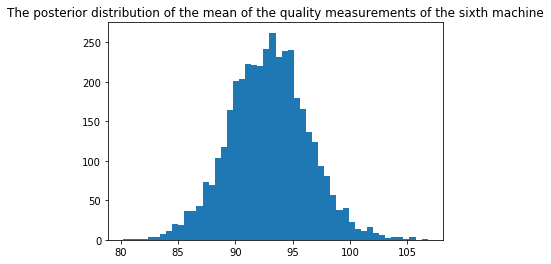

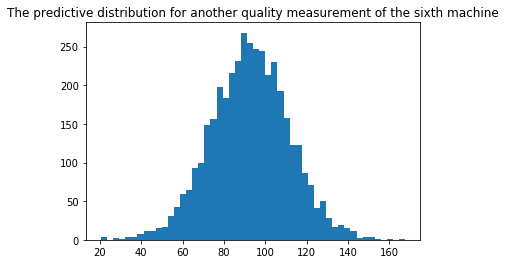

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,92.903675,0.067132,3.465873,86.006849,90.549084,92.908658,95.119507,99.715712,2665.427684,1.001989
sigma,18.797319,0.048482,2.554703,14.599759,16.974013,18.522052,20.306084,24.519731,2776.593225,0.999958
ypred,92.637703,0.304666,18.897875,55.492676,79.815349,92.764862,105.124940,129.523447,3847.487187,1.000829
lp__,-99.325371,0.024714,0.999124,-102.087670,-99.701913,-98.995652,-98.622371,-98.348872,1634.403468,1.002325


In [212]:
summary = pooled_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

mu6 = pooled_fit.extract(permuted=True)['mu']
plt.hist(mu6, bins=50)
plt.title('The posterior distribution of the mean of the quality measurements of the sixth machine')
plt.show()

ypred = pooled_fit.extract(permuted=True)['ypred']
plt.hist(ypred, bins=50)
plt.title('The predictive distribution for another quality measurement of the sixth machine')
plt.show()
summary

In [157]:
# HIERARCHICAL MODEL
df = pd.read_csv('factory.csv', sep=' ', header=None)
number_datapoints = df.shape[0] * df.shape[1]
num_groups = df.shape[1]
y = df.values
y = np.reshape(y, 30, order='F')
y = y.ravel()
x = np.arange(1,7)
x = np.repeat(x, 5)

In [177]:
hierarchical_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}

parameters {
    real mu0;             // prior mean
    real<lower=0> sigma0; // prior std
    
    vector[K] mu;         // group means
    real<lower=0> sigma;
}

model {
    mu ~ normal(mu0, sigma0);
    y ~ normal(mu[x], sigma);
}

generated quantities {
    real mu7;
    real ypred6;
    
    mu7 = normal_rng(mu0, sigma0);
    ypred6 = normal_rng(mu[6], sigma);
}
'''

hierarchical_factory_data = {'N': number_datapoints,
                'K': num_groups,
                'x': x,
                'y': y
               }

sm = pystan.StanModel(model_code = hierarchical_factory_code)
hierarchical_fit = sm.sampling(data = hierarchical_factory_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ea7cc0166d53f922973846a1f08bcbd NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmphg9t64sw/stanfit4anon_model_3ea7cc0166d53f922973846a1f08bcbd_6925287183214143246.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


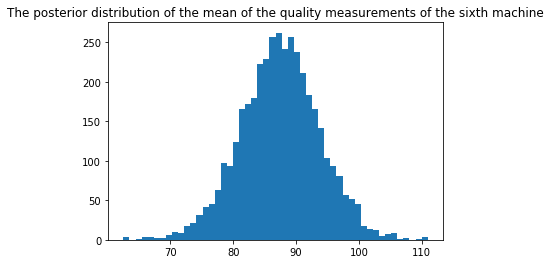

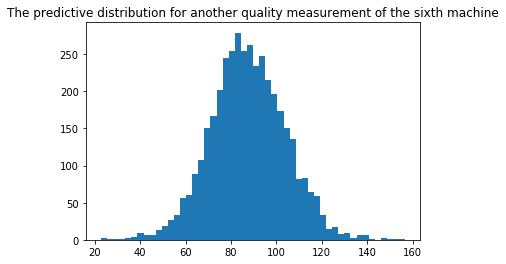

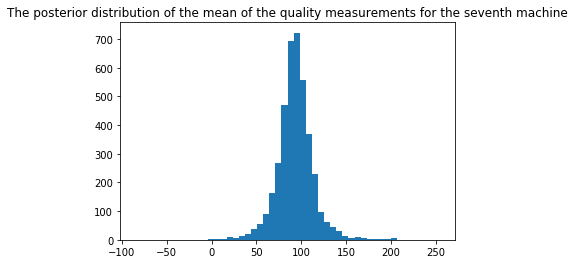

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu0,93.290717,0.191672,8.065943,77.532429,88.786215,93.215770,97.366603,110.066226,1770.896109,0.999533
sigma0,16.530071,0.257707,9.475592,5.074003,10.596897,14.500549,19.804258,40.900964,1351.952302,0.999976
mu[1],79.748155,0.148167,6.693119,66.724990,75.238848,79.788491,84.238018,92.774756,2040.587318,0.999868
mu[2],103.315051,0.133148,6.490323,90.503871,98.999169,103.388754,107.569849,116.230933,2376.098048,0.999457
mu[3],88.914996,0.095108,6.159341,76.933804,84.742608,88.884792,92.926337,100.788101,4194.014190,0.999936
mu[4],107.447232,0.166859,6.982580,93.645370,102.849551,107.532119,112.087451,121.512402,1751.195470,1.000679
mu[5],90.552264,0.103074,6.168650,78.140223,86.596270,90.664977,94.593697,102.814915,3581.622920,1.000597
mu[6],87.456315,0.107783,6.288880,74.806569,83.399964,87.530194,91.542560,99.573647,3404.466269,1.000175
sigma,15.204632,0.053481,2.369060,11.330319,13.536499,14.898735,16.562669,20.580568,1962.224334,1.000458
mu7,93.037188,0.373998,20.728368,50.922683,82.771702,92.922477,102.877504,135.680113,3071.796704,0.999698


In [213]:
summary = hierarchical_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

mu6 = hierarchical_fit.extract(permuted=True)['mu'][:,5]
plt.hist(mu6, bins=50)
plt.title('The posterior distribution of the mean of the quality measurements of the sixth machine')
plt.show()


ypred6 = hierarchical_fit.extract(permuted=True)['ypred6']
plt.hist(ypred6, bins=50)
plt.title('The predictive distribution for another quality measurement of the sixth machine')
plt.show()


mu7 = hierarchical_fit.extract(permuted=True)['mu7']
plt.hist(mu7, bins=50)
plt.title('The posterior distribution of the mean of the quality measurements for the seventh machine')
plt.show()

summary

In [77]:
# SEPARATE MODEL
df = pd.read_csv('factory.csv', sep=' ', header=None)
number_datapoints = df.shape[0] * df.shape[1]
num_groups = df.shape[1]
y = df.values
y = np.reshape(y, 30, order='F')
y = y.ravel()
x = np.arange(1,7)
x = np.repeat(x, 5)

In [166]:
separate_factory_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
}

parameters {
    vector[K] mu;         // group means
    //real<lower=0> sigma;
    vector<lower=0>[K] sigma;
}

model {
  y ~ normal(mu[x], sigma[x]);
}

generated quantities {
    real ypred;
    ypred = normal_rng(mu[6], sigma[6]);
}
'''

separate_factory_data = {'N': number_datapoints,
                'K': num_groups,
                'x': x,
                'y': y
               }

sm = pystan.StanModel(model_code = separate_factory_code)
separate_fit = sm.sampling(data = separate_factory_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_20fefd6af5e1230f82cd22dcec5ba598 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmps3x3bsbc/stanfit4anon_model_20fefd6af5e1230f82cd22dcec5ba598_6281881426530908145.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


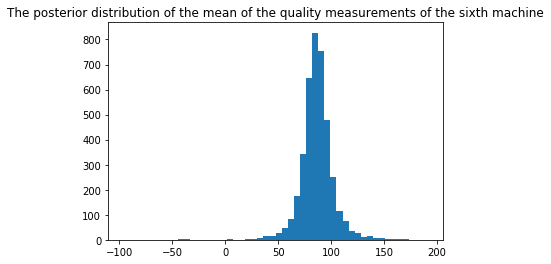

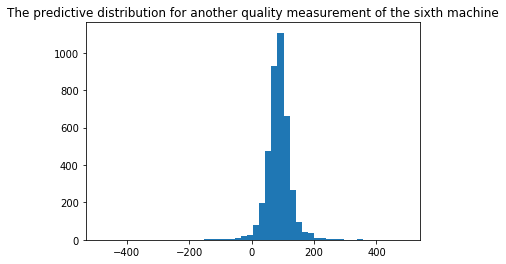

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu[1],75.582098,0.418068,16.281844,40.915098,67.608163,75.672937,83.693557,109.143701,1516.750456,1.000655
mu[2],106.569763,0.313585,10.126074,87.536720,101.658559,106.314505,111.325144,127.344576,1042.731666,0.999949
mu[3],87.613054,0.388218,11.644616,65.041092,82.758279,87.730068,92.839156,108.727831,899.701422,1.007002
mu[4],111.300095,0.182214,6.299879,97.827123,108.494049,111.510130,114.521611,123.100879,1195.360265,1.001410
mu[5],90.370026,0.464682,11.352094,72.654788,85.661524,90.035790,94.141070,110.245784,596.816191,1.004840
mu[6],86.341499,0.441310,16.386230,55.582679,78.890028,86.293642,93.971839,118.921958,1378.700317,1.000582
sigma[1],31.734972,0.613216,21.870842,12.795753,19.427410,25.623060,36.128867,88.095577,1272.050847,1.000767
sigma[2],19.166221,0.495446,15.320960,7.726608,11.709667,15.467722,21.743694,52.914915,956.266115,1.003641
sigma[3],20.895429,0.591418,16.503910,8.338049,12.662353,16.735960,23.406554,58.853097,778.726610,1.006456
sigma[4],11.866516,0.211255,7.697102,4.950060,7.488102,9.802157,13.680047,30.474180,1327.515580,1.000797


In [217]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

mu6 = separate_fit.extract(permuted=True)['mu'][:, 5]
plt.hist(mu6, bins=50)
plt.title('The posterior distribution of the mean of the quality measurements of the sixth machine')
plt.show()

ypred = separate_fit.extract(permuted=True)['ypred']
plt.hist(ypred, bins=50)
plt.title('The predictive distribution for another quality measurement of the sixth machine')
plt.show()
summary